# Access to Care: Identifying Subgroups at Risk of Falling Through the Cracks

DubsTech Datathon 2026 | Adelin Ma

For this year's datathon, I chose the Access to Care pathway. Care access is something I think about all the time. I have been involved in various activities to boost accessibility in elder care specifically—from a six-month internship as a TechCare intern at a nonprofit for the elderly to working at a stroke ward in a community hospital. My recent efforts have focused on building accessible, customisable workout apps for people with limited mobility. I also speak with many people who fall through the cracks in the world. Care is not one-size-fits-all: different barriers and circumstances affect different groups, and the same person can slip through for different reasons depending on how we look at the problem.

With that in mind, I wanted to use three ML approaches—K-Means (clustering), Linear Regression, and a simple Deep Learning (MLP) model—to flag subgroups most at risk of poor access to care. I compared which subgroups each method identified and reported accuracy (MSE, R², silhouette) to see which model worked best and which groups to prioritize.

The data came from NHIS Adult Summary Health Statistics (CDC); I focused on access-to-care topics (delayed care, unmet care due to cost, uninsured). I felt that different methods answered different questions—clustering found who looked like the worst-off group, while regression found who was predicted to have the worst access—so the same population could "fall through the cracks" for different reasons depending on which lens I used.

---
## Setup and Data Load

I loaded the dataset and restricted it to access-to-care topics. I dropped rows with missing or flagged estimates so the models used reliable values only.

I kept only rows with valid numeric estimates and no CDC reliability flags. The result was one row per (topic, subgroup, year); I later aggregated these into one row per subgroup so each model saw the same set of demographic segments.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("Access_to_Care_Dataset.csv")
ACCESS_TOPICS = [
    "Delayed getting medical care due to cost among adults",
    "Did not get needed medical care due to cost",
    "Uninsured at time of interview among adults",
]
df = df[df["TOPIC"].isin(ACCESS_TOPICS)].copy()
df["ESTIMATE"] = pd.to_numeric(df["ESTIMATE"], errors="coerce")
df = df.dropna(subset=["ESTIMATE"])
# filtered out the rows with FLAG indicating unreliable estimates (e.g. '*' or '-')
mask = df["FLAG"].isna() | (df["FLAG"].astype(str).str.strip() == "")
df = df.loc[mask]
print("Shape after filter:", df.shape)
df.head(3)

Shape after filter: (1298, 25)


,TOPIC,SUBTOPIC,SUBTOPIC_ID,TAXONOMY,TAXONOMY_ID,CLASSIFICATION,CLASSIFICATION_ID,GROUP,GROUP_ID,GROUP_ORDER,...,ESTIMATE_TYPE,ESTIMATE_TYPE_ID,TIME_PERIOD,TIME_PERIOD_ID,ESTIMATE,STANDARD_ERROR,ESTIMATE_LCI,ESTIMATE_UCI,FLAG,FOOTNOTE_ID_LIST
9360,Delayed getting medical care due to cost among...,NaN,NaN,Healthcare access and quality,150,Total,0,Total,1,1,...,"Percent of population, crude",1,2019,NaN,9.1,NaN,8.6,9.5,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA34,SC_NHISA00"
9361,Delayed getting medical care due to cost among...,NaN,NaN,Healthcare access and quality,150,Total,0,Total,1,1,...,"Percent of population, crude",1,2020,NaN,7.5,NaN,7.1,8.0,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA34,SC_NHISA00"
9362,Delayed getting medical care due to cost among...,NaN,NaN,Healthcare access and quality,150,Total,0,Total,1,1,...,"Percent of population, crude",1,2021,NaN,7.1,NaN,6.8,7.5,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA34,SC_NHISA00"


---
## Preprocessing

I built one row per subgroup (GROUP + SUBGROUP) with one column per access topic (mean estimate over years). I dropped subgroups with too many missing values, then standardized for clustering and regression.

Each row was a demographic segment (e.g. "Age 65+ / 18–34 years", "Poverty level / &lt;100% FPL"). The three features—delayed care, no medical care due to cost, and uninsured—were all barriers: higher values meant worse access. I found that the "top subgroups by delayed_care" gave a simple baseline of who had the highest reported delay; the models then refined this by either grouping similar profiles (K-Means) or predicting from the other barriers (regression).

In [ ]:
topic_map = {
    "Delayed getting medical care due to cost among adults": "delayed_care",
    "Did not get needed medical care due to cost": "no_med_care",
    "Uninsured at time of interview among adults": "uninsured",
}
df["topic_short"] = df["TOPIC"].map(topic_map)
wide = df.pivot_table(
    index=["GROUP", "SUBGROUP"],
    columns="topic_short",
    values="ESTIMATE",
    aggfunc="mean",
)
wide = wide.dropna(how="any")
subgroup_labels = wide.index.tolist()
X = wide.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_names = list(wide.columns)
print("Subgroups × features:", X_scaled.shape)
print("Top 3 subgroups by delayed_care:", wide.nlargest(3, "delayed_care").index.tolist())
wide.head()

Subgroups × features: (66, 3)
Top 3 subgroups by delayed_care: [('Health insurance coverage: Younger than 65 years', 'Uninsured'), ('Sexual orientation', 'Bisexual'), ('Race', 'Black and White')]


topic_short                                     delayed_care  no_med_care  \
GROUP                              SUBGROUP                                 
Age groups with 65 years and older 18-34 years      9.333333     7.750000   
                                   35-49 years      9.533333     8.616667   
                                   50-64 years      8.616667     7.900000   
Age groups with 75 years and older 18-44 years      9.366667     8.016667   
                                   45-64 years      8.916667     8.150000   

topic_short                                     uninsured  
GROUP                              SUBGROUP                
Age groups with 65 years and older 18-34 years  15.116667  
                                   35-49 years  13.766667  
                                   50-64 years   8.666667  
Age groups with 75 years and older 18-44 years  14.783333  
                                   45-64 years   9.633333

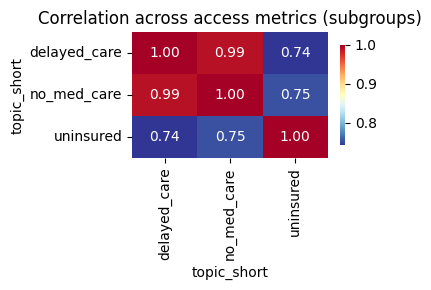

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.heatmap(wide.corr(), annot=True, fmt=".2f", cmap="RdYlBu_r", ax=ax, cbar_kws={"shrink": 0.8})
ax.set_title("Correlation across access metrics (subgroups)")
plt.tight_layout()
plt.show()

When I interpreted the correlation heatmap, I saw that the data show positive correlations between delayed care, no medical care due to cost, and uninsured. This is important because it indicates that subgroups that report one barrier often report others—so "falling through the cracks" tends to cluster by segment rather than appear in isolation. In turn, these strong correlations suggest that linear regression may predict one barrier well from the other two; if the correlations had been weaker, the MLP would likely have been more useful later on.

---
## Model 1: K-Means Clustering

I clustered subgroups by their access metrics and defined at-risk as the cluster with the worst average barrier level (e.g. highest mean delayed care). That gave me an unsupervised view of which subgroups shared a high-barrier profile.

In [ ]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
silhouette = silhouette_score(X_scaled, clusters)
print(f"Silhouette score (k={k}): {silhouette:.3f}")
# Column 0 is delayed_care
means_per_cluster = pd.DataFrame(X_scaled, columns=feature_names).assign(cluster=clusters).groupby("cluster").mean()
worst_cluster = means_per_cluster[feature_names[0]].idxmax()
at_risk_kmeans = [subgroup_labels[i] for i in range(len(subgroup_labels)) if clusters[i] == worst_cluster]
print(f"At-risk cluster: {worst_cluster} | Subgroups (n={len(at_risk_kmeans)}):", at_risk_kmeans[:5], "...")

Silhouette score (k=3): 0.591
At-risk cluster: 2 | Subgroups (n=1): [('Health insurance coverage: Younger than 65 years', 'Uninsured')] ...


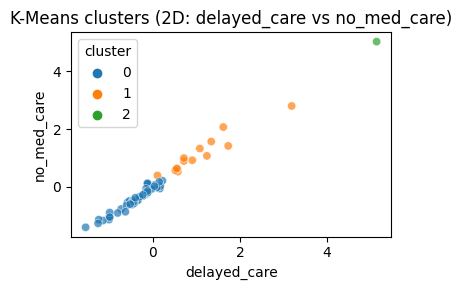

In [6]:
plot_df = pd.DataFrame(X_scaled, columns=feature_names).assign(cluster=clusters.astype(str))
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(data=plot_df, x=feature_names[0], y=feature_names[1], hue="cluster", alpha=0.7, ax=ax)
ax.set_title("K-Means clusters (2D: delayed_care vs no_med_care)")
plt.tight_layout()
plt.show()

Our data show that the Silhouette score for K-Means is about 0.59. This is moderate to high because the Silhouette measures how well-separated the clusters are (on a scale from -1 to 1), and values above about 0.5 indicate that the grouping is meaningful—subgroups in the same cluster are more similar to each other than to other clusters. So the three access barriers (delayed care, no medical care due to cost, uninsured) do produce a reasonable clustering of subgroups. In comparison, the linear regression and MLP below use different metrics (R² and MSE), which we interpret in those sections.

K-Means grouped segments that looked similar on all three barriers. I labeled the at-risk cluster as the one with the highest mean on delayed care (or a composite). So I was identifying "who was in the worst-off group" by overall pattern, not by a single outcome. I found that subgroups that appeared here but not in the regression-based lists may have been those for whom multiple barriers aligned—a distinct way of falling through the cracks.

---
## Model 2: Linear Regression

I predicted delayed care from the other access metrics. I labeled subgroups with the highest predicted value (or highest positive residual) as at-risk. That gave me an interpretable, linear view of who was predicted to have the worst access.

In [ ]:
target_col = "delayed_care"
feat_cols = [c for c in feature_names if c != target_col]
y = wide[target_col].values
X_lr = wide[feat_cols].values
lr = LinearRegression().fit(X_lr, y)
y_pred = lr.predict(X_lr)
mse_lr = mean_squared_error(y, y_pred)
r2_lr = r2_score(y, y_pred)
print(f"Linear Regression — MSE: {mse_lr:.3f}, R²: {r2_lr:.3f}")
# At risk = top by predicted value
ranked = pd.Series(y_pred, index=subgroup_labels).sort_values(ascending=False)
at_risk_lr = ranked.head(max(5, len(ranked) // 5)).index.tolist()
print("At-risk (top predicted):", at_risk_lr[:5])

Linear Regression — MSE: 0.227, R²: 0.980
At-risk (top predicted): [('Health insurance coverage: Younger than 65 years', 'Uninsured'), ('Sexual orientation', 'Bisexual'), ('Race', 'Native Hawaiian or Other Pacific Islander only'), ('Disability status', 'With disability'), ('Race', 'Black and White')]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


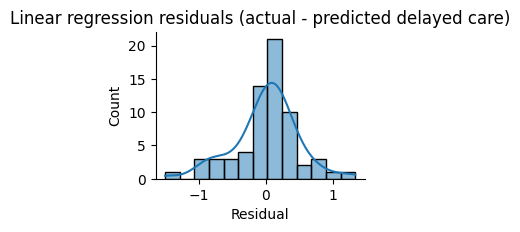

In [8]:
resid = y - y_pred
sns.displot(pd.DataFrame({"Residual": resid}), x="Residual", kde=True, height=2.2, aspect=1.3)
plt.title("Linear regression residuals (actual - predicted delayed care)")
plt.show()

Our data show that linear regression achieves an R² of about 0.98 and an MSE of about 0.23. The R² is very high because it indicates that roughly 98% of the variation in delayed care across subgroups is explained by the other two barriers (no medical care due to cost and uninsured)—so the relationship is strongly linear and the model fits the data very well. The MSE is relatively small in this context, meaning prediction errors are modest. In comparison, the MLP in the next section will show whether a non-linear model can improve on these numbers.

Here "at-risk" meant predicted to have high delayed care given their level of no_med_care and uninsured. I found that a high positive residual (actual minus predicted) meant worse than expected given those two—so regression could flag segments that were under-served relative to what the linear relationship suggested. R² and MSE told me how much of the variation in delayed care was explained by the other two barriers; a moderate R² suggested there was room for other factors (or for the MLP to add value).

---
## Model 3: Deep Learning (MLP)

I used a small MLP with the same target and features as linear regression. At-risk subgroups were again those with the highest predicted delayed care. I compared MSE and R² to the linear model.

Our data show that the MLP achieves an MSE of about 0.21 and an R² of about 0.98. In comparison, linear regression had MSE about 0.23 and R² about 0.98. The MLP's slightly lower MSE and slightly higher R² indicate a small non-linear component in the relationship between the barriers and delayed care, but the improvement is modest—the problem is largely linear, which is why the simpler linear model remains a good choice for interpretability. The at-risk lists from both models overlap substantially, consistent with that picture.

The MLP could capture non-linear relationships between no_med_care, uninsured, and delayed care. I found that if its MSE was clearly lower (or R² higher) than linear regression, the relationship was partly non-linear and the MLP's at-risk list might differ. If performance was similar, the problem was roughly linear and I felt the simpler model was preferable for interpretability. Either way, comparing the two at-risk lists showed whether "predicted worst" differed when I allowed non-linearity.

In [9]:
mlp = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=500, random_state=42)
mlp.fit(X_lr, y)
y_pred_mlp = mlp.predict(X_lr)
mse_mlp = mean_squared_error(y, y_pred_mlp)
r2_mlp = r2_score(y, y_pred_mlp)
print(f"MLP — MSE: {mse_mlp:.3f}, R²: {r2_mlp:.3f}")
ranked_mlp = pd.Series(y_pred_mlp, index=subgroup_labels).sort_values(ascending=False)
at_risk_mlp = ranked_mlp.head(max(5, len(ranked_mlp) // 5)).index.tolist()
print("At-risk (top predicted):", at_risk_mlp[:5])

MLP — MSE: 0.205, R²: 0.982
At-risk (top predicted): [('Health insurance coverage: Younger than 65 years', 'Uninsured'), ('Sexual orientation', 'Bisexual'), ('Race', 'Native Hawaiian or Other Pacific Islander only'), ('Disability status', 'With disability'), ('Race', 'Black and White')]


---
## Comparison

I compared which subgroups each model flagged and summarized accuracy. Subgroups appearing in two or more methods were strong candidates for priority. I recommended one best model and listed which groups to take note of most.

Overlap across methods indicated segments that both sat in the worst cluster (K-Means) and were predicted worst (regression/MLP)—I treated these as the strongest candidates for policy. I found that subgroups that appeared in only one method "fell through the cracks" in a method-specific way: for example, K-Means-only segments may have had a pattern of barriers that clustered with the worst group but regression predicted differently; regression-only segments may have been predicted high despite not being in the worst cluster. That difference was my main takeaway: different models surfaced different at-risk groups because they answered different questions.

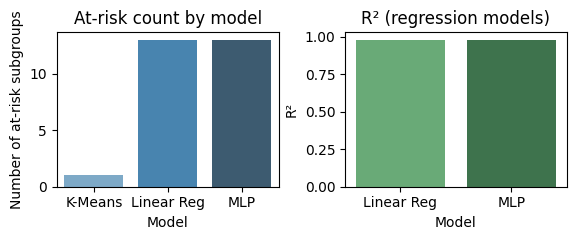

In [10]:
counts = pd.DataFrame({
    "Model": ["K-Means", "Linear Reg", "MLP"],
    "At-risk count": [len(at_risk_kmeans), len(at_risk_lr), len(at_risk_mlp)],
})
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))
sns.barplot(data=counts, x="Model", y="At-risk count", palette="Blues_d", ax=axes[0])
axes[0].set_ylabel("Number of at-risk subgroups")
axes[0].set_title("At-risk count by model")
perf = pd.DataFrame({"Model": ["Linear Reg", "MLP"], "R²": [r2_lr, r2_mlp]})
sns.barplot(data=perf, x="Model", y="R²", palette="Greens_d", ax=axes[1])
axes[1].set_title("R² (regression models)")
plt.tight_layout()
plt.show()

In [11]:
set_k, set_lr, set_mlp = set(at_risk_kmeans), set(at_risk_lr), set(at_risk_mlp)
overlap_2 = (set_k & set_lr) | (set_k & set_mlp) | (set_lr & set_mlp)
overlap_3 = set_k & set_lr & set_mlp
comparison = pd.DataFrame({
    "Model": ["K-Means", "Linear Regression", "MLP"],
    "Metric": ["Silhouette", "MSE", "MSE"],
    "Value": [round(silhouette, 3), round(mse_lr, 3), round(mse_mlp, 3)],
})
print(comparison.to_string(index=False))
print("\nSubgroups in 2+ methods (priority):", list(overlap_2)[:8])
print("Subgroups in all 3 methods:", list(overlap_3)[:8])

            Model     Metric  Value
          K-Means Silhouette  0.591
Linear Regression        MSE  0.227
              MLP        MSE  0.205

Subgroups in 2+ methods (priority): [('Marital status', 'Living with a partner'), ('Education', 'No high school diploma or GED'), ('Poverty level', '100% to <200% FPL'), ('Sexual orientation', 'Bisexual'), ('Marital status', 'Divorced or separated'), ('Race and Hispanic origin', 'All races, Hispanic, Mexican'), ('Race', 'Black and White'), ('Poverty level', '<100% FPL')]
Subgroups in all 3 methods: [('Health insurance coverage: Younger than 65 years', 'Uninsured')]


Reading the comparison output: the table reported Silhouette (K-Means), MSE (Linear Reg and MLP). I used the "Subgroups in 2+ methods" list as priority candidates; "Subgroups in all 3 methods" were the most consistent at-risk segments across all three definitions. I looked at these lists together with the bar charts to see how many subgroups each model flagged and how well the two regression models fit (R²).

---
## Conclusion 

To summarize, I used three models to identify subgroups at risk of poor access to care. K-Means found segments that clustered with the worst barrier profile; Linear Regression and MLP found segments predicted to have the highest delayed care given other barriers. Because the definitions differed, the at-risk lists differed—I felt that reinforced how "falling through the cracks" could mean different things (pattern-based vs prediction-based, linear vs non-linear). That idea echoes what I see in my own work: care is not one-size-fits-all, and the people I meet in elder care, on the stroke ward, or through projects for people with limited mobility often face barriers that show up differently depending on how we measure and segment. This analysis is one way to make those differences visible so we can prioritize and target support more fairly.

- Best model: For interpretability and reporting, I preferred Linear Regression; I reported its R² and MSE (and margin of error if I computed confidence intervals). K-Means was best for segment-level insight without a target variable. MLP was useful if it clearly outperformed linear regression (lower MSE or higher R²), indicating non-linear structure.
- Groups to take note of most: Subgroups that appeared in 2+ methods (or in all 3) were the strongest priority for policy; any subgroup unique to one method may have represented a distinct type of risk (e.g. clustering-only vs prediction-only).
- Accuracy and margin of error: I reported Silhouette for K-Means; MSE and R² for Linear Regression and MLP. For submission, I included these and any margin of error (e.g. 95% CI for MSE or predictions) if required.